# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 24.12.2023 23:59 MSK

Жёсткий дедлайн: 24.12.2023 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from __future__ import annotations

from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])

class Boosting:

    def __init__(
            self,
            base_model_params: dict = None,
            n_estimators: int = 10,
            learning_rate: float = 0.1,
            subsample: float = 0.3,
            early_stopping_rounds: int = None,
            plot: bool = False,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []
        self.validation_losses = []
        self.train_losses = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)

        self.plot: bool = plot

        self.history = defaultdict(list)

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

        self.no_improvement_count = 0

    def predict_proba(self, x):
        predictions = np.zeros(x.shape[0])
        for gamma, model in zip(self.gammas, self.models):
          predictions += gamma * model.predict(x)
        return np.array([1 - self.sigmoid(predictions), self.sigmoid(predictions)]).T

    def fit_new_base_model(self, x, y, predictions):
        indexes = np.random.choice(x.shape[0], size=int(self.subsample * x.shape[0]), replace = True)
        x_bootstrap = x[indexes]
        y_bootstrap = y[indexes]
        s = -self.loss_derivative(y_bootstrap,predictions[indexes])
        base_model = self.base_model_class(**self.base_model_params)
        base_model.fit(x_bootstrap, s)
        gamma = self.find_optimal_gamma(y, predictions, base_model.predict(x))
        self.models.append(base_model)
        self.gammas.append(gamma * self.learning_rate)
    def fit(self, x_train, y_train, x_valid, y_valid):
        """
        :param x_train: features array (train set)
        :param y_train: targets array (train set)
        :param x_valid: features array (validation set)
        :param y_valid: targets array (validation set)
        """
        train_predictions = np.zeros(y_train.shape[0])
        valid_predictions = np.zeros(y_valid.shape[0])
        self.validation_losses.append(self.loss_fn(y_valid, valid_predictions))
        self.train_losses.append(self.loss_fn(y_train, train_predictions))
        for i in range(self.n_estimators):
            self.fit_new_base_model(x_train, y_train, train_predictions)
            train_predictions += self.gammas[-1] * self.models[-1].predict(x_train)
            valid_predictions += self.gammas[-1] * self.models[-1].predict(x_valid)
            self.train_losses.append(self.loss_fn(y_train, train_predictions))
            self.validation_losses.append(self.loss_fn(y_valid, valid_predictions))
            if self.early_stopping_rounds is not None:
                if i >= self.early_stopping_rounds and np.all(np.diff(self.validation_losses[-self.early_stopping_rounds:]) >= 0):
                    break
        if self.plot:
          fig = plt.figure()
          plt.plot(list(range(0, len(self.validation_losses))), self.validation_losses)
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.title('GBM Losses')


    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]

        return gammas[np.argmin(losses)]

    def score(self, x, y):
        return score(self, x, y)

    @property
    def feature_importances_(self):
      return np.mean([model.featur_importances_ for model in self.models], axis = 0)

In [ ]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from boosting import Boosting

In [ ]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [ ]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 1.77 s, sys: 1.7 ms, total: 1.77 s
Wall time: 1.77 s
Train ROC-AUC 0.9906
Valid ROC-AUC 0.9127
Test ROC-AUC 0.9122


## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [ ]:
results = {}
depths = range(1, 30, 2)
for i in depths:
  model = Boosting(base_model_params = {'max_depth': i})
  model.fit(x_train, y_train, x_valid, y_valid)
  results[i] = [model.score(x_valid, y_valid)]
  results[i].append(model.score(x_train, y_train))

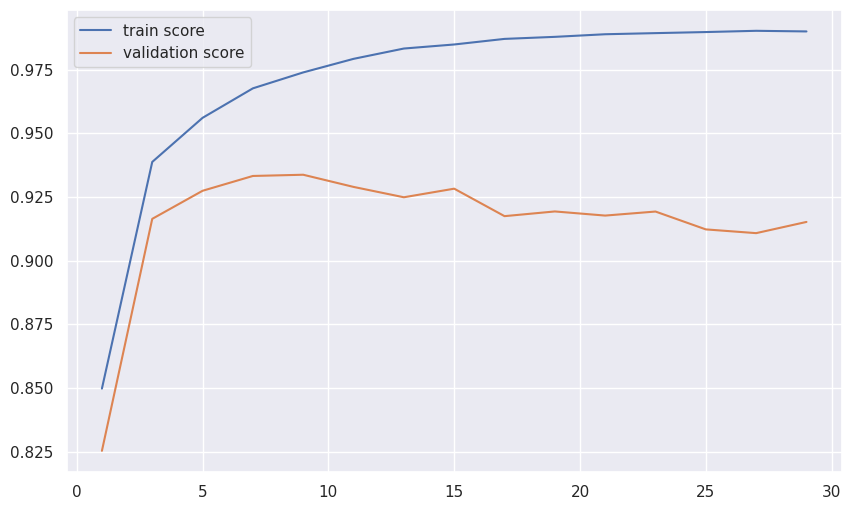

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), [values[1] for values in results.values()], label='train score')
plt.plot(list(results.keys()), [values[0] for values in results.values()], label='validation score')
plt.legend()

In [ ]:
max_val_score = max([values[0] for values in results.values()])
max_val_depth = depths[[values[0] for values in results.values()].index(max_val_score)]
plt.axvline(x=max_val_depth, color='red', linestyle='--', label=f'Max validation score at depth {max_val_depth}')

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Конечно, на трейне лучше качество дает максимально глубокое дерево, поскольку деревья очень легко переобучаются, и глубокие деревья идеально подстраиваются под обучающую выборку. На валидационной же все немного иначе. Здесь нужно взять не слишком глубокое, не слишком не глубокое дерево, глубиной 7 - здесь хорошее качество и на трейне (и дальше оно растет не так значительно), и на валидационной.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [ ]:
import optuna

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    n_estimators = trial.suggest_int('n_estimators', 5, 100)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 3, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    base_model_params ={
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10)
    }
    model = Boosting(
        learning_rate = learning_rate,
        n_estimators = n_estimators,
        early_stopping_rounds = early_stopping_rounds,
        subsample = subsample,
        base_model_params = base_model_params
    )
    model.fit(x_train, y_train, x_valid, y_valid)
    score = model.score(x_valid, y_valid)
    return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2023-12-24 19:25:27,282] A new study created in memory with name: no-name-aab39e99-4509-473c-8f76-044e2acf7928
[I 2023-12-24 19:25:39,281] Trial 0 finished with value: 0.9395158812068328 and parameters: {'learning_rate': 0.5973026616459096, 'n_estimators': 77, 'early_stopping_rounds': 8, 'subsample': 0.8746738889683666, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9395158812068328.
[I 2023-12-24 19:25:41,308] Trial 1 finished with value: 0.9297472208985555 and parameters: {'learning_rate': 0.5264906590040914, 'n_estimators': 40, 'early_stopping_rounds': 5, 'subsample': 0.12630028565906737, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9395158812068328.
[I 2023-12-24 19:25:45,894] Trial 2 finished with value: 0.9313368182351519 and parameters: {'learning_rate': 0.15167612068214364, 'n_estimators': 84, 'early_stopping_rounds': 7, 'subsample': 0.3016718388750459, 'max_depth': 3, 'min_sample

{'learning_rate': 0.9294690647254309, 'n_estimators': 86, 'early_stopping_rounds': 9, 'subsample': 0.9250963925219127, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5}


Вот наши лучшие гиперпараметры:

{'learning_rate': 0.9294690647254309, 'n_estimators': 86, 'early_stopping_rounds': 9, 'subsample': 0.9250963925219127, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5}

## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

Используем код из 4 домашки.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = (1.0 / n_bins) * i
        r = (1.0 / n_bins) * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.grid(True)
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot(bin_middle_points, bin_middle_points)
    plt.ylim([-0.05, 1.05])
    plt.grid()

In [ ]:
best_params = {'learning_rate': 0.9294690647254309, 'n_estimators': 86, 'early_stopping_rounds': 9, 'subsample': 0.9250963925219127, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5}

In [ ]:
base_model_params = {
    'max_depth': best_params['max_depth'],
    'min_samples_leaf': best_params['min_samples_leaf'],
    'min_samples_split': best_params['min_samples_split']
}

In [ ]:
model = Boosting(
    base_model_params = base_model_params,
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    subsample = best_params['subsample'],
    early_stopping_rounds = best_params['early_stopping_rounds']
)

In [ ]:
model.fit(x_train, y_train, x_valid, y_valid)

In [ ]:
preds = model.predict_proba(x_test)[:, 1]

In [ ]:
from sklearn.calibration import calibration_curve

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
true_boosting, pred_boosting = calibration_curve(y_test, preds, n_bins = 10)

In [ ]:
clflog = LogisticRegression(random_state = 42, max_iter=10000, C=0.1)
clflog.fit(x_train, y_train)

LogisticRegression(C=0.1, max_iter=10000, random_state=42)

In [ ]:
y_log_pred = clflog.predict_proba(x_test)[:, 1]

In [ ]:
true_logreg, pred_logreg = calibration_curve(y_test,y_log_pred, n_bins = 10)

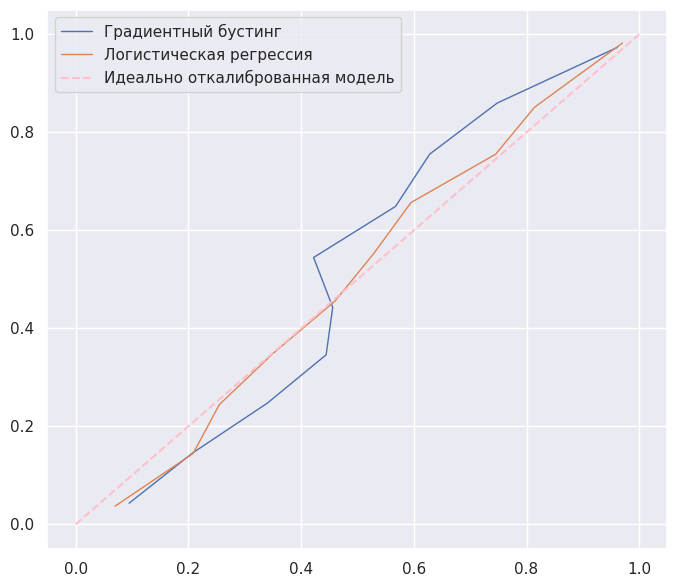

In [ ]:
plt.figure(figsize = (8, 7))
plt.plot(true_boosting, pred_boosting, linewidth = 1, label = 'Градиентный бустинг')
plt.plot(true_logreg, pred_logreg, linewidth = 1, label = 'Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', color = 'pink', label = 'Идеально откалиброванная модель')
plt.legend()

Вообще, на удивление, у логрега калибровочная прямая лучше. Это из-за того, что бустинг у нас очень "неуверенный")) Он вообще, видимо, не приспособлен, чтобы вычислять вероятности. Мы просто берем сигмоиду от предиктов (это вообще никакого смысла не имеет по сути), а вот логрег реально вероятности предсказывает, это круто! Но у бустинга все равно аукрок хороший.